In [2]:
from IPython.display import HTML

In [3]:
import pandas as pd

from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

import json
%matplotlib inline
dict_drey = json.load(open('boardDreyfus.json'))

In [4]:
dict_drey.keys()

[u'labels',
 u'actions',
 u'id',
 u'datePluginDisable',
 u'subscribed',
 u'idTags',
 u'pinned',
 u'shortUrl',
 u'closed',
 u'checklists',
 u'prefs',
 u'dateLastActivity',
 u'lists',
 u'invitations',
 u'dateLastView',
 u'members',
 u'powerUps',
 u'desc',
 u'descData',
 u'labelNames',
 u'name',
 u'shortLink',
 u'idOrganization',
 u'invited',
 u'memberships',
 u'url',
 u'pluginData',
 u'cards',
 u'starred']

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


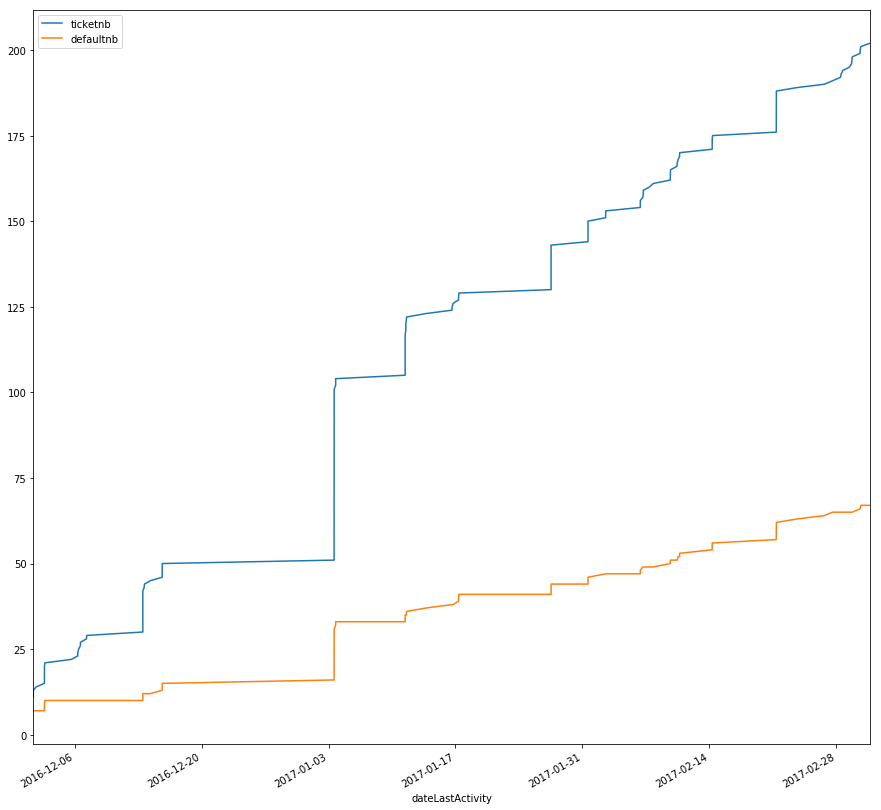

In [36]:
defaults_ids = set([l['id'] for l in dict_drey['labels'] if l['color']=='red'])
list_done = [l['id'] for l in dict_drey['lists'] if l['name'].lower().find('done')>-1]
df_cards= json_normalize(dict_drey['cards'])
df_tickets = df_cards[df_cards['idList'].isin(list_done)]
bac_rouge = df_tickets[df_tickets['idLabels'].map(lambda x: len(set(x)&defaults_ids)> 0)]
bac_rouge.dateLastActivity = pd.to_datetime(bac_rouge.dateLastActivity)
df_tickets['is_default'] = df_tickets['idLabels'].map(lambda x: len(set(x)&defaults_ids)> 0)
df_tickets.dateLastActivity = pd.to_datetime(df_tickets.dateLastActivity , format='%Y-%m-%d %H:%M:%S.%f')
df_tickets= df_tickets[df_tickets.name.map(lambda x:x.find('(')>-1)]
df_tickets[['is_default', 'name']].groupby('is_default').count()
df_tickets['estim'] = df_tickets.name.map(lambda x: x[1])
df_tickets = df_tickets[df_tickets['estim'].isin([u'3', u'2', u'1',u'4'])]
df_tickets['estim'] =df_tickets['estim'].map(int)
df_tickets['post_eval'] = df_tickets.name.map(lambda x: int(x[-2]) if x[-1]==']' else -1)
df_tickets = df_tickets.sort('dateLastActivity')
df_tickets['is_default'] = df_tickets['is_default'] | (df_tickets['post_eval']>df_tickets['estim'])
df_tickets['is_default'] = df_tickets['is_default'].map(int)
df_tickets['one']=1
df_tickets['ticketnb'] = df_tickets['one'].cumsum()
df_tickets['defaultnb'] = df_tickets['is_default'].cumsum()
df_tickets[df_tickets.set_index('dateLastActivity').index>"2016.12"].set_index('dateLastActivity')[['ticketnb', 'defaultnb']].plot(figsize = (15,15))

In [ ]:
(df_tickets.set_index('dateLastActivity')['defaultnb']/ df_tickets.set_index('dateLastActivity')['ticketnb']).plot()

In [ ]:
with open('arborescence_dreyfus.txt' ) as f:
    arbo = f.read()

In [ ]:
arr_path = map(lambda x: x[1:].replace('/','.') + ',',arbo.splitlines())

In [ ]:
path_series = pd.Series(arr_path)

In [ ]:
path_series = path_series.map(lambda x:x[1:] if x[0]=='.' else x)

In [ ]:
def cropIfIsInSeries(x):
    if x.count('.')==0 :return x
    tmp = '.'.join(x.split('.')[0:-1])
    if list(path_series.values).count(tmp)==1 : 
        return x
    return tmp

In [ ]:
path_series = path_series.map(lambda x:x[:-1] if x[-1]==',' else x)

path_series =path_series.map(cropIfIsInSeries)

path_series = path_series.map(lambda x:x+',')

In [ ]:
with open('treeD3/arbo.csv', 'w') as f:
    f.write('id,value\nroot,\n' + '\n'.join(path_series.map(lambda x: 'root.'+x).unique()))

In [ ]:
with open('arbo_dreyfus.json', 'w') as f:
    json.dump(list(path_series.map(lambda x: x.strip(',').strip('.'))\
.drop_duplicates()\
.map(lambda x: {'id': ('root.'+x).strip('.'),'value':''}).values), f,  indent=4)


In [ ]:
# from string import Template

# with open('treeD3/html_template.html') as f:
#     html_template = Template(f.read())



# viz = html_template.substitute({'python_data': json.dumps(list(path_series.map(lambda x: x.strip(',').strip('.'))\
# .drop_duplicates()\
# .map(lambda x: {'id': ('root.'+x).strip('.'),'value':''}).values), indent =4)})

# HTML(viz) 

In [ ]:
with open('arbo_dreyfus.json') as f:
    arbo_dict = json.load(f)

In [ ]:
hier_dict = {}

In [ ]:
id_list = [k['id'] for k in arbo_dict]

In [ ]:
end_nodes = [k for k in id_list if len(filter(lambda x: k+'.' in x, id_list))==0]
    
    

In [ ]:
def initDIct():
    hier_dict = {'name': 'root', 'children': []}
    for n in end_nodes:
        d = hier_dict
        keys = n.split('.')
        for k in keys[:-1]:
            if d['name'] == k:
                continue
            l = filter(lambda x:x['name']==k, d['children'])
            if len(l)>0: 
                d = l[0]
                continue
            dd = {'name': k, 'children': []}    
            d['children'].append(dd)
            d=dd
        d['children'].append({'name': keys[-1], 'size':0})
    return hier_dict



with open('treeD3collaps/arbo_hier.json', 'w') as f:
    json.dump(hier_dict, f)

In [ ]:
with open('donuts./arbo_hier.json', 'w') as f:
    json.dump(hier_dict, f)

In [ ]:
hier_dict = initDIct()

In [ ]:
hier_dict

In [ ]:
df_tickets.shape

In [ ]:
df_tickets[df_tickets.is_default.map(lambda x:x==1)].shape

In [ ]:
import json

In [ ]:
with open('CirclePack/arbo_hier.json') as f:
    arbo = json.load(f)

In [ ]:
import os


In [ ]:
os.listdir('.')

In [ ]:
with open('commit_hash_filechanged.json') as f:
    commits_file = json.load(f)
with open('commit_hash_ticket.json') as f:
    commits_tickets = json.load(f)
df_co_ti = pd.DataFrame([commits_tickets.keys(), commits_tickets.values()]).T
dfco_fc = pd.read_json('commit_hash_filechanged.json', orient = 'index')
df_co_ti[1] = df_co_ti[1].map(lambda x:x[1:-1])
dfco_fc.drop(0,1, inplace = True)
df_co_ti.head()
df_co_ti.columns = ['hash', 'ticket']
dfco_fc.columns = ['files']
dfco_fc.head()
df_files = df_co_ti.set_index('hash').join(dfco_fc)
df_files.shape
df_files.drop_duplicates(['ticket']).shape
df_files.head()
df_files.dropna(subset = ['ticket']).shape
df_files.groupby('ticket').count().sort_values('files', ascending = 0)
dffoo = df_files.groupby('ticket').agg({'files': lambda x:list(x)})
df_tickets.idShort =df_tickets.idShort.map(str)
df_tickets = df_tickets.join(dffoo, on='idShort')

In [ ]:
a = 1/0


In [ ]:
a  = float('nan')

In [ ]:
np.isnan(a)

In [ ]:
if a.isnan(): print 'ocucou'

In [ ]:
df_tickets.columns

In [ ]:
import seaborn as sns

In [ ]:
df_tickets.shape

In [ ]:
df_tickets.is_default.fillna(0, inplace=1)

In [ ]:
(df_tickets[df_tickets.is_default].groupby(['nbfileschanged']).size()/\
df_tickets.groupby(['nbfileschanged']).size()).fillna(0).plot(kind='bar')

In [ ]:
foobar = df_tickets[['nbfileschanged', 'is_default', u'one']]\
.pivot_table(index=['nbfileschanged'], columns=[u'is_default'])['one'].fillna(0)

In [ ]:
foobar.columns = ['T', 'F']

In [ ]:
df_tickets.groupby(['nbfileschanged']).size().plot(kind='bar', ylim=(0,15))

In [ ]:
df_tickets.nbfileschanged.head()

In [ ]:
df_tickets.files.fillna(-1, inplace=True)

In [ ]:
df_tickets['nbfileschanged'] =df_tickets.files.map(lambda ff:len([xx for x in ff for xx in x.splitlines()]) if not ff==-1 else -1)

In [ ]:
[len([xx for x in ff for xx in x.splitlines()]) if not ff==-1 else -1 for ff in df_tickets.files.values]

In [ ]:
from operator import getitem

In [ ]:
[xx for x in dffoo.head().values[0][0] for xx in x.splitlines()]

In [ ]:
dffoo.files = dffoo.files.map(lambda y: [xx for x in y  for xx in x.splitlines()])

In [ ]:
%whos

In [ ]:
test = dffoo.files[0][0]

In [ ]:
test.split('/')

In [ ]:
hier_dict = initDIct()

for foo in df_tickets.files.values:
    if foo==-1: continue
    for test in foo:
        d = hier_dict
        try: 
            for f in test.split('/')[1:]:
                f= f.split('.')[0]
                d = filter(lambda x:x['name']==f, d['children'])[0]
            d['size']+=1
        except:
            pass

def filter_fn(dd):
    return not (( dd.has_key('size') and dd['size']==0) or (dd.has_key('children') and len(dd['children'])==0))


def remove_0(d):
    if d.has_key('size'): return
    if d.has_key('children'):
        for dd in d['children']: 
            remove_0(dd)
        d['children'] = filter(filter_fn, d['children'])
            

remove_0(hier_dict)

In [ ]:
hier_dict

In [ ]:
filter(lambda x:x['name']==f, d['children'])

In [ ]:
map(lambda x:x['name'], hier_dict['children'])

In [ ]:
d.keys()

In [ ]:
from string import Template

with open('CirclePack/html_template.html') as f:
    html_template = Template(f.read())



viz = html_template.substitute({'python_data': json.dumps(hier_dict)})

HTML(viz) 

In [ ]:
with open('file_modified.json', 'w') as f:
    json.dump(hier_dict, f, encoding='utf-8')

In [ ]:
hier_dict

In [ ]:
df_tickets[df_tickets.is_default==1].files.dropna().values[0]

In [ ]:
df_tickets[(df_tickets.is_default==0) & (df_tickets.files!=-1)].shape


In [ ]:
hier_dict = initDIct()

for foo in df_tickets[df_tickets.is_default==1].files:
    if foo==-1: continue
    print len(foo)
    for test in foo[0].splitlines():
        d = hier_dict
        try: 
            for f in test.split('/'):
                f= f.split('.')[0]
                d = filter(lambda x:x['name']==f, d['children'])[0]
            d['size']+=1
        except:
            pass



In [ ]:
remove_0(hier_dict)

In [ ]:
def filter_fn(dd):
    return not (( dd.has_key('size') and dd['size']==0) or (dd.has_key('children') and len(dd['children'])==0))


def remove_0(d):
    if d.has_key('size'): return
    if d.has_key('children'):
        for dd in d['children']: 
            remove_0(dd)
        d['children'] = filter(filter_fn, d['children'])
            

remove_0(hier_dict)

In [ ]:
with open('donuts/file_modified_default.json', 'w') as f:
    json.dump(hier_dict, f, encoding='utf-8')

In [ ]:
hier_dict


In [ ]:
df_tickets.idShort =df_tickets.idShort.map(str)

In [ ]:
hier_dict = initDIct()

for foo in df_tickets[df_tickets.is_default==0].files.dropna():
    for test in foo:
        d = hier_dict
        try: 
            for f in test.split('/'):
                f= f.split('.')[0]
                d = filter(lambda x:x['name']==f, d['children'])[0]
            d['size']+=1
        except:
            pass

remove_0(hier_dict)

In [ ]:
with open('file_modified_not_default.json', 'w') as f:
    json.dump(hier_dict, f, encoding='utf-8')